This notebook processes raw data output from Cell Ranger (isolated all valid 10 Chromium barcodes droplets and gathered in a gene x droplet count matrix). The goal is to identify which droplets contain real cells vs which are mostly empty or containing dying cells. Much bigger amount of droplets are empty. The cell-containing droplets are identified by their UMI (unique molecular identifier-tagged RNA molecules) counts number. If the droplet has too few counts then the cell rpobably degraded and all the RNA leaked out.

Import scanpy and pandas to process the Anndata object and its metadata which is in the form of dataframes.

In [3]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import glob
from pathlib import Path


Open the files for the different datasets recursively

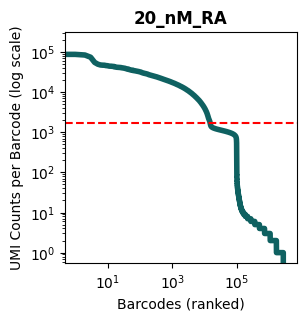

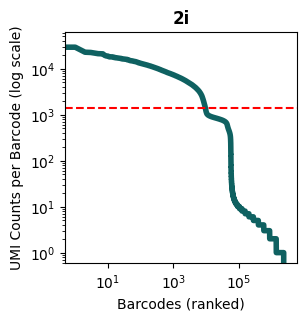

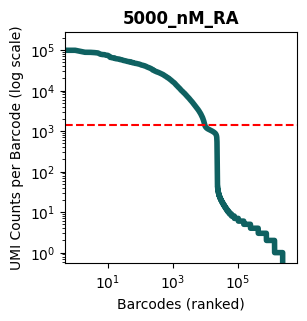

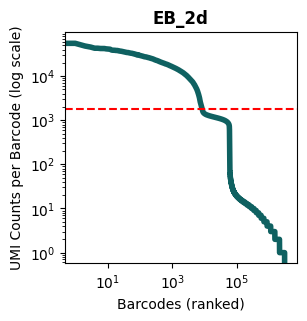

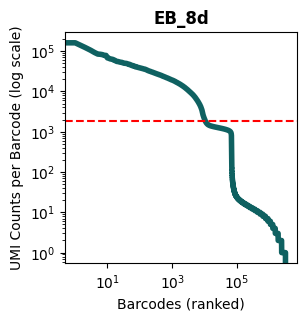

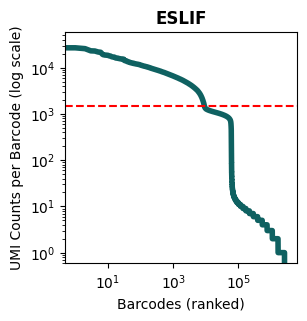

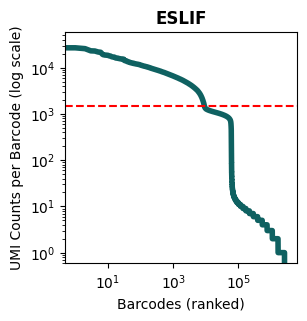

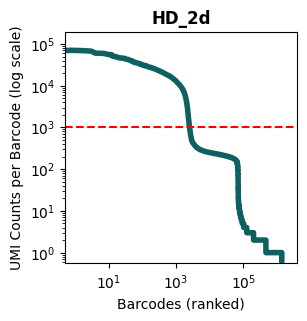

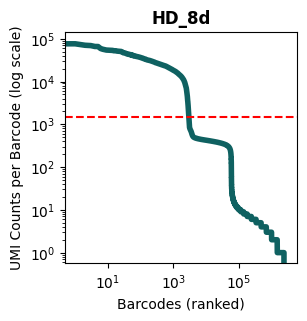

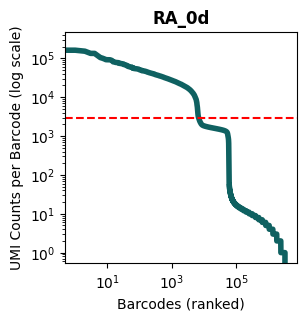

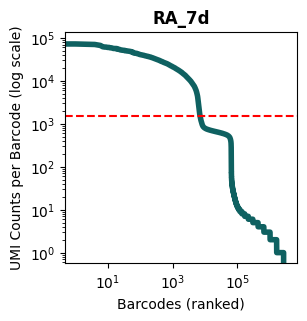

In [5]:
files = glob.glob('Anndata_Objects/output/**/raw_matrix/*.*', recursive=True)

Those are cutoff values for UMI counts determined after looking at the plots. The general way is to look at the upper "knee" part of the plot and place the threshold at around half of the descending line (the "cliff")

In [ ]:
dict_cutoff = {'20_nM_RA': 1700 , 'ESLIF': 1500 , '2i': 1400 ,'5000_nM_RA': 1400,'EB_2d': 1800 ,'EB_8d': 1900 ,'HD_2d': 1000 ,\
               'HD_8d': 1500 ,'RA_0d': 3000 ,'RA_7d': 1500} 

For the knee plots displayed here, barcodes are ranked by their total UMI count amount, e.g. the barcode with the highest UMI count is labeled "1" and so on with integer numbers and this is plotted on the X-axis. On the y-axis UMI count number is plotted.

In [ ]:
def knee_plot(sample, sorted_counts, umi_cutoff):
    '''
    Make knee plots to visualise the amount of droplets (valid barcodes) within given UMI count ranges.

    Args:
        sample (str): the sample (or dataset) identifier

    Returns:
        None
    '''
    fig, ax = plt.subplots(figsize=(3,3))
    # plot the ranked barcodes labelled with integer numbers and plot them according to their UMI counts
    plt.plot(range(len(sorted_counts)), sorted_counts, color="#0F6161", linewidth=4)
    plt.yscale("log") # as there are too many barcodes and UMI counts respectively
    plt.xscale("log")  
    plt.xlabel("Barcodes (ranked)")
    plt.ylabel("UMI Counts per Barcode (log scale)")
    plt.title(f"{sample}", weight='bold', fontsize=12)
    # adjust this cutoff based on the "knee" location in the plot
    umi_cutoff = dict_cutoff[sample]  
    plt.axhline(umi_cutoff, color="red", linestyle="--")
    plt.savefig(f'knee_plot{sample}.png', bbox_inches='tight')
    plt.show()

Create Anndata object from the count matrix and metadata. The metadata could be gene-specific, usually includes gene names (as gene symbols), gene IDs (such as Ensembl) as index and cell-specific - e.g. the unique barcode for each cell. As such the gene-specific metadata is put in var_names and the .var slot dataframe whereas the barcode names are added as obs_names (obs_names is the index of all the .obs dataframe columns that will be added later)

In [ ]:
for file in files:
    sample = Path(file).parts[1]
    if 'barcodes.tsv' in file:
        
        # open file with cell metadata, barcodes
        barcodes = pd.read_table(file, header=None) 
        barcodes.columns=['barcode']
    elif 'features.tsv' in file:
        
        # open file with gene metadata such as gene names
        features = pd.read_table(file, header=None) 
        features.columns=['gene_id', 'gene_name', 'data_type']
    elif 'matrix.mtx' in file:
        
        #open file with the counts matrics and create an Anndata object from it
        adata = sc.read_mtx(file)
        adata = adata.T # transpose so that the matrix is in the cells (droplets) x features format
        adata.obs_names = np.asarray(barcodes['barcode']).flatten()
        adata.var_names = np.asarray(features['gene_id']).flatten()
        
        # obtain plotting metrics
        barcode_counts = adata.X.sum(axis=1).A1 # sums UMI counts for every cell to get a distribution of all existing UMI counts in the data for a cell
        sorted_counts = np.sort(barcode_counts)[::-1] # sorts the existing UMI counts 
        
        #make knee plots
        knee_plot(sample, sorted_counts, umi_cutoff)
        adata.obs['total_counts'] = barcode_counts
        
        #filter adata
        adata = adata[adata.obs['total_counts'] >= umi_cutoff]
        adata.write_h5ad(f'new_data/not_raw/filtered_{sample}.h5ad', compression='gzip') # save Anndata file with filtered droplets

References:
1. Zheng, G., Terry, J., Belgrader, P. et al. Massively parallel digital transcriptional profiling of single cells. Nat Commun 8, 14049 (2017). https://doi.org/10.1038/ncomms14049